# Create Multi Needle In A Haystack Visualization

Let's run through how to create the visualization for the Multi Needle In A Hackstack Test.

At a highlevel, it's a two step process
1. Read your results (e.g., from LangSmith dataset or local)
2. Plot your scores with respect to contet length (as done in Gemini 1.5 [paper](https://storage.googleapis.com/deepmind-media/gemini/gemini_v1_5_report.pdf)

```
Note: the analysis does not currently track the score per location of the needle.
```

We follow how Google resported results:

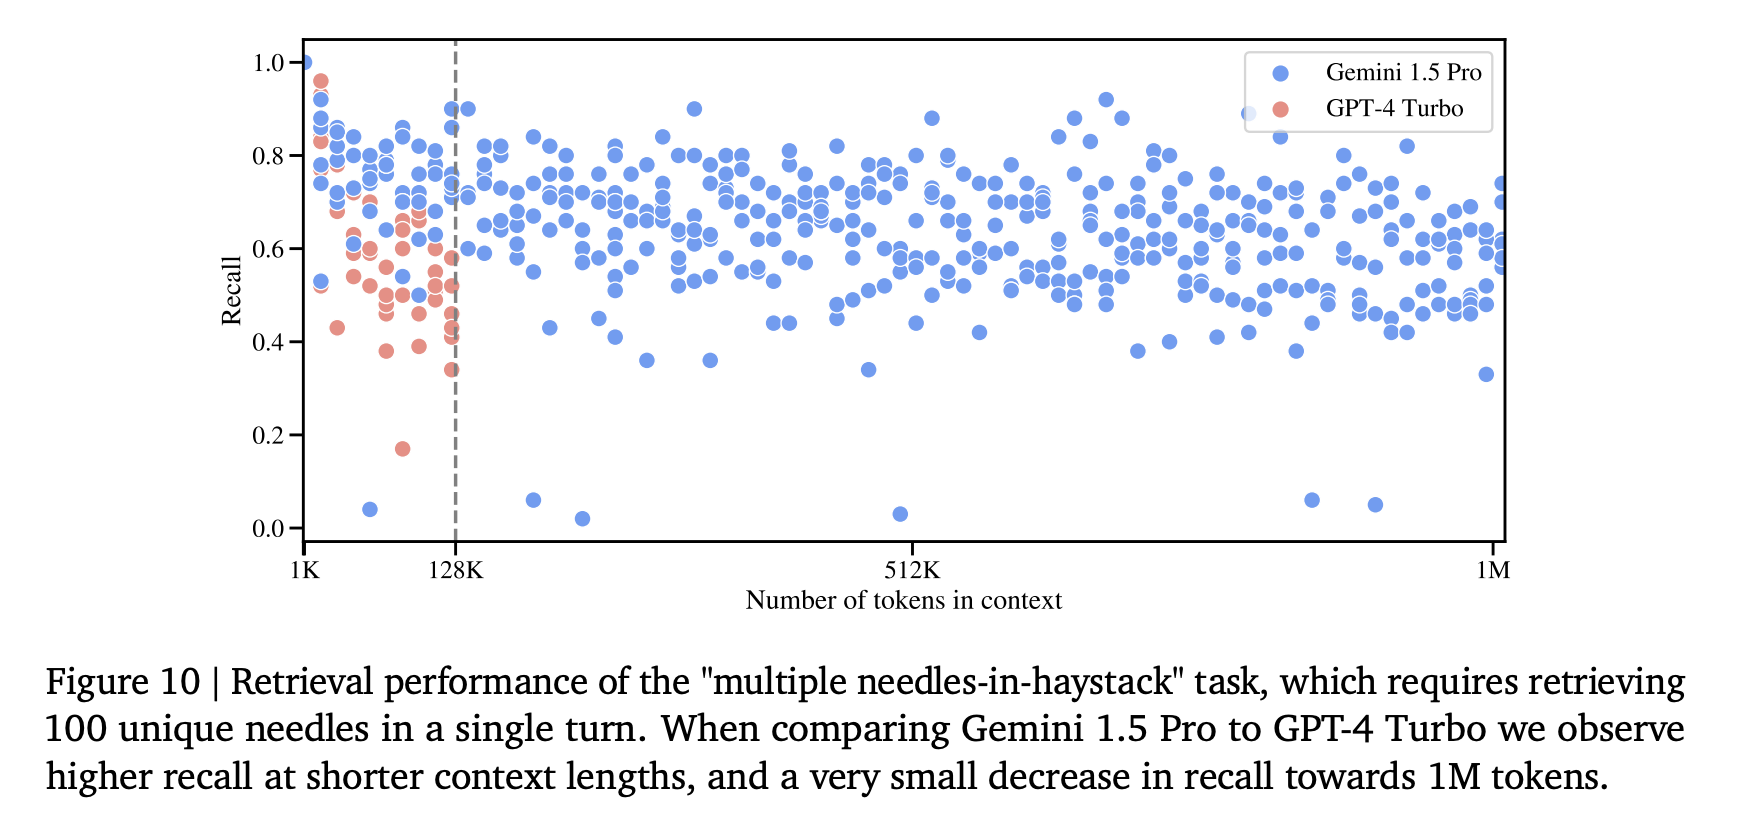

## Get results

In [142]:
# Eval set name for LangSmith
eval_sets = ["multi-needle-eval-pizza-1","multi-needle-eval-pizza-3","multi-needle-eval-pizza-10"]

In [143]:
import pandas as pd 
from langsmith.client import Client

# Get all runs for a given eval set
client = Client()

# Store
all_data = []

# Iterate through eval sets 
for set in eval_sets:

    # All runs for the given eval set
    projects = client.list_projects(reference_dataset_name=set)
    
    # Iterate through the runs on the eval set
    for p in projects:
        project = client.read_project(project_name=p.name)
        runs = list(client.list_runs(project_id=project.id, execution_order=1))
        if client.run_is_shared(run_id=runs[0].id):
            url = client.read_run_shared_link(runs[0].id)    
        else:
            url = client.share_run(run_id=runs[0].id)     
        # Extract the desired information from each project
        data = {
            'run_name': project.name,
            'run_url': url,
            'depth %': project.metadata['depth_percent'],
            'context length': project.metadata['context_length'],
            'retrieved needles': project.feedback_stats['needles_retrieved']['avg'],
            'model name': project.metadata['model_name'],
            'total needles': project.metadata['num_needles']
        }
        
        # Add the data dictionary to the list
        all_data.append(data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_data)
df['percent'] = df['retrieved needles'] / df['total needles']

## Plot

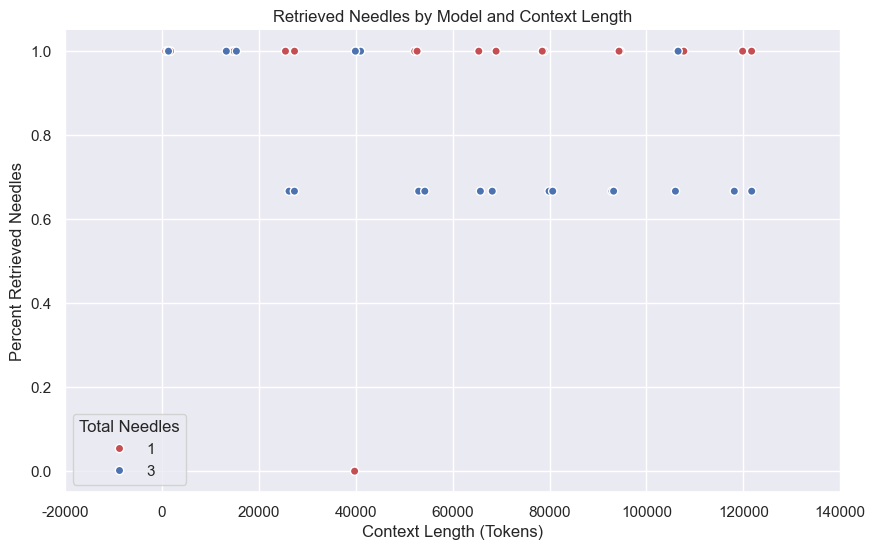

In [149]:
def plot(df,model):

    # Setting the theme
    sns.set_theme(style="darkgrid")

    df = df[df["model name"]==model].copy()
    
    # Adjusting df['context length'] to add jitter
    # Assuming 'context length' is numeric. Adjust the scale of jitter depending on your data range
    jitter_strength = 2000  # Example jitter strength, adjust based on your data scale
    df['context length jittered'] = df['context length'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="context length jittered", y="percent", hue="total needles", palette=['r', 'b'],
                    edgecolor='white', linewidth=1)  # Added edgecolor and linewidth for outline
    sns.despine()
    
    # Adding labels and title for clarity
    plt.xlabel("Context Length (Tokens)")
    plt.ylabel("Percent Retrieved Needles")
    plt.title("Retrieved Needles by Model and Context Length")
    plt.legend(title='Total Needles')
    
    # Optionally, adjust x-axis labels to reflect actual 'context length' values if needed
    plt.xticks(ticks=plt.xticks()[0], labels=[str(int(x)) for x in plt.xticks()[0]])
    
    # Display the plot
    plt.show()

plot(df,"gpt-4-0125-preview")